In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import sys

In [2]:
def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1 - np.square(tanh(x))

def sigmoid(y):
    return 1.0/(1.0+np.exp(-y))

def d_sigmoid(x):
    z = sigmoid(x)*(1-sigmoid(x))
    return z


def softmax(x):
    m = nn.Softmax(dim=0)
    return m(torch.tensor(x)).numpy()

def d_softmax(z):
    '''
    return the jacobian of the softmax
    '''
    z = softmax(z)
    return np.diag(z) - np.outer(z,z)

def MSE(a,b):
    return np.sum(np.square(a-b)) 

def d_MSE(output_activations, y):
    return (output_activations - y) 

In [3]:
class RNN:

    def __init__(self,input_dim,hidden_dim,output_dim,lr):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim 
        self.output_dim = output_dim
        self.w_in = np.random.uniform(-1,1, (hidden_dim, input_dim)) 
        self.b_in = np.random.uniform(-1,1, (hidden_dim, 1))
        self.w_hidden = np.random.uniform(-1,1, (hidden_dim, hidden_dim)) 
        self.b_hidden = np.random.uniform(-1,1, (hidden_dim, 1))
        self.w_out = np.random.uniform(-1,1, (output_dim, hidden_dim)) 
        self.b_out = np.random.uniform(-1,1, (output_dim, 1))
        self.loss = []
        self.lr = lr

    def forward(self, x):
        hidden_state = np.zeros((self.hidden_dim,1))
        prediction = np.zeros((len(x),1))
        for i in range(len(x)):
            x_in = self.w_in @ x[i].reshape(1,1) + self.b_in
            x_hid = self.w_hidden @ hidden_state + self.b_hidden
            # hid_out = tanh(x_in + x_hid)
            hid_out = sigmoid(x_in + x_hid)
            hidden_state = hid_out
            x_out = self.w_out @ hid_out + self.b_out
            prediction[i] = x_out
        return prediction
    
    def update(self, input, label):
        
        for x,y in zip(input, label):

            dldb_in,dldb_hidden,dldb_out,dldw_in,dldw_hidden,dldw_out,loss = self.backprop(x, y)
            self.w_in -= self.lr * dldw_in  
            self.b_in -= self.lr * dldb_in
            self.w_hidden -= self.lr * dldw_hidden
            self.b_hidden -= self.lr * dldb_hidden
            self.w_out -= self.lr * dldw_out
            self.b_out -= self.lr * dldb_out
            self.loss.append(loss) 
    
    def backprop(self, x, y):
        hidden_state = np.zeros((self.hidden_dim,1))
        hidden_out = []
        hidden_out.append(hidden_state)
        hidden_z = []
        y_out = []
        dldw_in = np.zeros(self.w_in.shape)
        dldb_in = np.zeros(self.b_in.shape)
        dldw_hidden = np.zeros(self.w_hidden.shape)
        dldb_hidden = np.zeros(self.b_hidden.shape)
        dldw_out = np.zeros(self.w_out.shape)
        dldb_out = np.zeros(self.b_out.shape)
        loss = 0
        
        for i in range(len(x)):
            x_in = self.w_in @ x[i].reshape(1,1) + self.b_in
            x_hid = self.w_hidden @ hidden_state + self.b_hidden
            hidden_z.append(x_in+x_hid)
            # hid_out = tanh(x_in + x_hid)
            hid_out = sigmoid(x_in + x_hid)
            hidden_out.append(hid_out)
            hidden_state = hid_out
            x_out = self.w_out @ hid_out + self.b_out
            y_out.append(x_out)
            loss += MSE(x_out,y[i])
        '''
        dldw_out 
        '''
        for i in range(1,len(x)+1):
            dldb_out += d_MSE(y_out[-i].reshape(1,1),y[-i].reshape(1,1))
            dldw_out += d_MSE(y_out[-i].reshape(1,1),y[-i].reshape(1,1)) @ np.transpose(hidden_out[-i]) 

        '''
        dldw_hidden
        dldw_input
        '''
        for i in range(1,len(x)+1):
            
            delta = d_MSE(y_out[-i].reshape(1,1),y[-i].reshape(1,1))
            delta = np.transpose(self.w_out) @ delta * d_sigmoid(hidden_z[-i])
            # delta = np.transpose(self.w_out) @ delta * d_tanh(hidden_z[-i])
            dldb_hidden += delta
            dldb_in += delta
            dldw_hidden += delta @ np.transpose(hidden_out[-i-1])
            dldw_in += delta @ np.transpose(x[-i].reshape(1,1))
            
            for k in range(i+1,len(x)):
                # delta = np.transpose(self.w_hidden) @ delta * d_tanh(hidden_z[-k])
                delta = np.transpose(self.w_hidden) @ delta * d_sigmoid(hidden_z[-k])
                dldb_hidden += delta
                dldb_in += delta
                dldw_hidden += delta @ np.transpose(hidden_out[-k-1])
                dldw_in += delta @ np.transpose(x[-i].reshape(1,1))
        
        return (dldb_in,dldb_hidden,dldb_out,dldw_in,dldw_hidden,dldw_out,loss)
            
         

In [4]:
input = []
label = []
for i in range(50):
    points = np.linspace(i, i+5, 51)
    sinwave = np.sin(points*np.random.uniform(1,10)).reshape(51,1)
    x = sinwave[:-1]
    y = sinwave[1:]
    input.append(x)
    label.append(y)

input = np.array(input)
label = np.array(label)



In [5]:
sinrnn = RNN(1,100,1,0.001)
Loss = []
for i in range(100):
    sinrnn.update(input,label)
    Loss.append(np.sum(sinrnn.loss))
    print('epoch',i,': ',np.sum(sinrnn.loss))
    sinrnn.loss.clear()


epoch 0 :  31575.506064963454
epoch 1 :  608.8808344523062
epoch 2 :  398.3895602769395
epoch 3 :  288.32998750392335
epoch 4 :  227.03242963590068
epoch 5 :  192.03774130939297
epoch 6 :  170.11738825397444
epoch 7 :  154.7329707838068
epoch 8 :  143.03961817991086
epoch 9 :  133.72764770776706
epoch 10 :  126.08575202718626
epoch 11 :  119.6661617534669
epoch 12 :  114.1599321790303
epoch 13 :  109.34267219210444
epoch 14 :  105.04730545225436
epoch 15 :  101.14868695519537
epoch 16 :  97.55370860632073
epoch 17 :  94.19409857496942
epoch 18 :  91.02078964300087
epoch 19 :  87.99942959650767
epoch 20 :  85.106820069072
epoch 21 :  82.3281085244746
epoch 22 :  79.65456971751664
epoch 23 :  77.08183906527893
epoch 24 :  74.60849689284967
epoch 25 :  72.23493749860795
epoch 26 :  69.96248280938859
epoch 27 :  67.79271444389924
epoch 28 :  65.72700116738181
epoch 29 :  63.7661946879751
epoch 30 :  61.91046088617187
epoch 31 :  60.15921070587701
epoch 32 :  58.511097241464306
epoch 33 :  

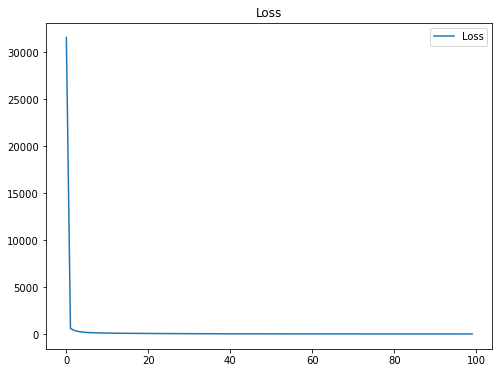

In [13]:
plt.figure(figsize = (8, 6))
plt.plot(Loss, label = 'Loss', markersize = 3)
plt.title("Loss")
plt.legend()
plt.show()

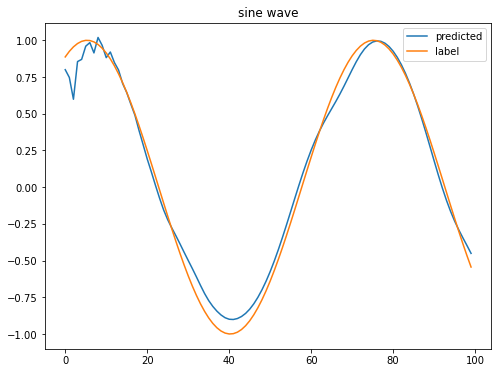

In [16]:
points = np.linspace(1, 10, 101)
sinwave = np.sin(points).reshape(101,1)
test_input = sinwave[:-1]
test_label = sinwave[1:]
predicted = sinrnn.forward(test_input)
plt.figure(figsize = (8, 6))
plt.plot(predicted, label = 'predicted', markersize = 3)
plt.plot(test_label, label = 'label', markersize = 3)
plt.title("sine wave")
plt.legend()
plt.show()

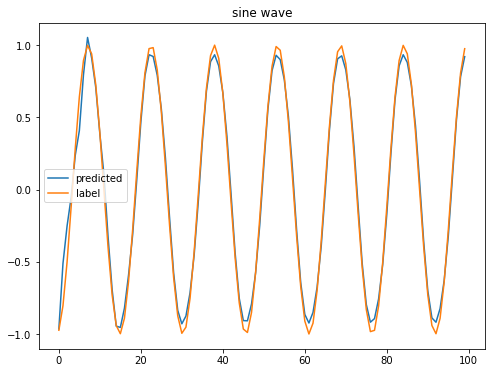

In [17]:
points = np.linspace(1, 10, 101)
sinwave = np.sin(np.random.uniform(0,5)*points).reshape(101,1)
test2_input = sinwave[:-1]
test2_label = sinwave[1:]
predicted2 = sinrnn.forward(test2_input)
plt.figure(figsize = (8, 6))
plt.plot(predicted2, label = 'predicted', markersize = 3)
plt.plot(test2_label, label = 'label', markersize = 3)
plt.title("sine wave")
plt.legend()
plt.show()

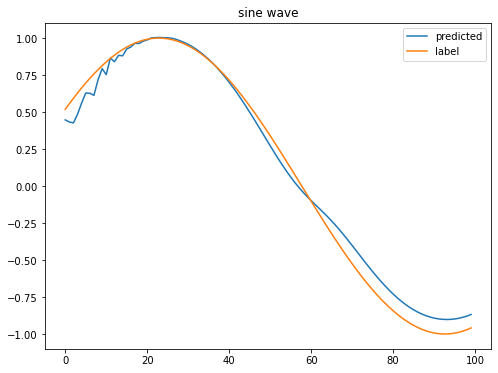

In [18]:
points = np.linspace(1, 10, 101)
sinwave = np.sin(0.5*points).reshape(101,1)
test3_input = sinwave[:-1]
test3_label = sinwave[1:]
predicted3 = sinrnn.forward(test3_input)
plt.figure(figsize = (8, 6))
plt.plot(predicted3, label = 'predicted', markersize = 3)
plt.plot(test3_label, label = 'label', markersize = 3)
plt.title("sine wave")
plt.legend()
plt.show()

In [19]:
input = []
label = []
for i in range(50):
    points = np.linspace(i, i+5, 51)
    sinwave = np.sin(points).reshape(51,1)
    x = sinwave[:-1]
    y = sinwave[1:]
    input.append(x)
    label.append(y)

input = np.array(input)
label = np.array(label)

sinrnn = RNN(1,100,1,0.001)
Loss = []
for i in range(100):
    sinrnn.update(input,label)
    Loss.append(np.sum(sinrnn.loss))
    print('epoch',i,': ',np.sum(sinrnn.loss))
    sinrnn.loss.clear()

epoch 0 :  49284.26648487225
epoch 1 :  171.3226712078521
epoch 2 :  121.2442425116688
epoch 3 :  91.4655907642681
epoch 4 :  72.19987623599005
epoch 5 :  59.0168787094716
epoch 6 :  49.54843214422811
epoch 7 :  42.44940280892995
epoch 8 :  36.92664731338177
epoch 9 :  32.50328278760356
epoch 10 :  28.890292179590638
epoch 11 :  25.909533293420534
epoch 12 :  23.443485689376274
epoch 13 :  21.40321860193962
epoch 14 :  19.712250706157256
epoch 15 :  18.302439801233987
epoch 16 :  17.115320620912204
epoch 17 :  16.103494076225953
epoch 18 :  15.230204402960682
epoch 19 :  14.46761286007001
epoch 20 :  13.794738871648109
epoch 21 :  13.195648832189399
epoch 22 :  12.658066482288996
epoch 23 :  12.17237353284075
epoch 24 :  11.73090920189496
epoch 25 :  11.327480712477406
epoch 26 :  10.957017622603729
epoch 27 :  10.615323321974929
epoch 28 :  10.298892557808083
epoch 29 :  10.004774522621595
epoch 30 :  9.730468047446562
epoch 31 :  9.473839960120074
epoch 32 :  9.233060561607346
epoch 

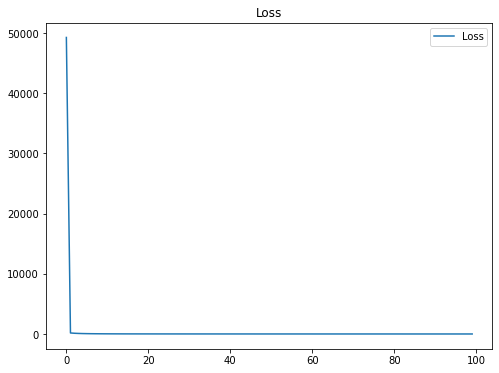

In [20]:
plt.figure(figsize = (8, 6))
plt.plot(Loss, label = 'Loss', markersize = 3)
plt.title("Loss")
plt.legend()
plt.show()

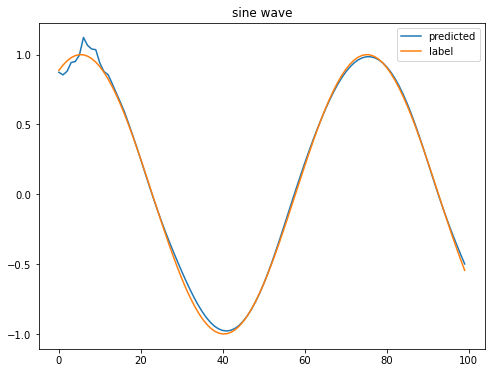

In [21]:
points = np.linspace(1, 10, 101)
sinwave = np.sin(points).reshape(101,1)
test_input = sinwave[:-1]
test_label = sinwave[1:]
predicted = sinrnn.forward(test_input)
plt.figure(figsize = (8, 6))
plt.plot(predicted, label = 'predicted', markersize = 3)
plt.plot(test_label, label = 'label', markersize = 3)
plt.title("sine wave")
plt.legend()
plt.show()

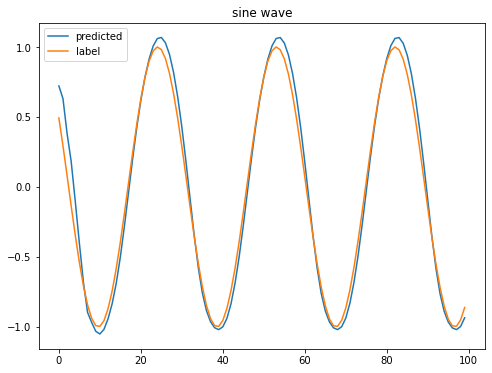

In [23]:
points = np.linspace(1, 10, 101)
sinwave = np.sin(np.random.uniform(0,5)*points).reshape(101,1)
test2_input = sinwave[:-1]
test2_label = sinwave[1:]
predicted2 = sinrnn.forward(test2_input)
plt.figure(figsize = (8, 6))
plt.plot(predicted2, label = 'predicted', markersize = 3)
plt.plot(test2_label, label = 'label', markersize = 3)
plt.title("sine wave")
plt.legend()
plt.show()

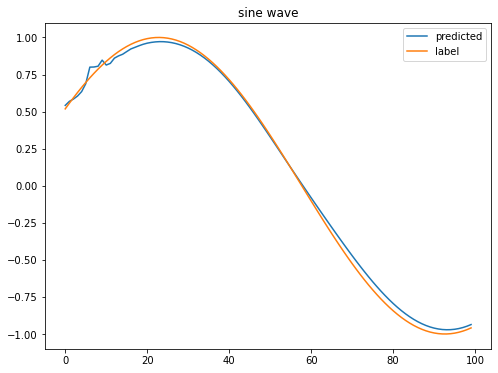

In [22]:
points = np.linspace(1, 10, 101)
sinwave = np.sin(0.5*points).reshape(101,1)
test3_input = sinwave[:-1]
test3_label = sinwave[1:]
predicted3 = sinrnn.forward(test3_input)
plt.figure(figsize = (8, 6))
plt.plot(predicted3, label = 'predicted', markersize = 3)
plt.plot(test3_label, label = 'label', markersize = 3)
plt.title("sine wave")
plt.legend()
plt.show()

In [3]:
import numpy as np
np.random.randint(0, 10)

9